In [9]:
# autoreload modules when files have been altered
%load_ext autoreload
%autoreload 2

import os, sys, time
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt

sys.path.append("/home/andy/Documents/Research/SF/GitRepo/seestar/")
import SelectionGrid
import IsochroneScaling
import ArrayMechanics
#from seestar import ArrayMechanics
#from seestar import SelectionGrid

import seaborn as sns

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
from seestar import surveyInfoPickler
fileinfo = surveyInfoPickler.surveyInformation('/media/andy/37E3-0F91/Research/SF/SFdata/Galaxia3_new/Galaxia3_new_fileinfo.pickle')
fileinfo.spectro_model = ('GMM', 1)
fileinfo.photo_model = ('GMM', 2)
#fileinfo.photo_coords = ['glon', 'glat', 'Japp', 'Kapp', 'Happ']
fileinfo.save()

In [11]:
fileinfo_path = '/media/andy/37E3-0F91/Research/SF/SFdata/Galaxia3_new/Galaxia3_new_fileinfo.pickle'
SF = SelectionGrid.SFGenerator(fileinfo_path, ncores=3)

Would you like the selection function in: a) observable, b) intrinsic, c) both? (return a, b or c)a
Path to observable SF (Galaxia3_new_obsSF.pickle) exists. Use this to ? (y/n)n
The spectro model description is:('GMM', 1)
The photo model description is:('GMM', 2)

{'glon': 'phi', 'Colmin': 'Colmin', 'glat': 'theta', 'Colmax': 'Colmax', 'Magmin': 'Magmin', 'Magmax': 'Magmax', 'fieldID': 'fieldID', 'halfangle': 'halfangle'}
Importing data for Colour-Magnitude Field interpolants...
{'Kapp': 'appB', 'Happ': 'appC', 'glon': 'phi', 'glat': 'theta', 'Japp': 'appA', 'fieldID': 'fieldID'}
Filtering for null values in spectro: Total star count = 5847. Filtered star count = 5847. 0 stars removed with null values
((8.001017701622784, 13.499959932502573), (0.5000188162888577, 1.1835355696129728))
...done.

Creating Colour-Magnitude Field interpolants...
multiprocessing - observable SF calculation - running on 3 cores...
Current field in col-mag calculation: 1.0, 1/3, Time: 1m, Left: 0m
now picklin

# Calculate union for set of stars

In [ ]:
IsoCalculator = IsochroneScaling.IntrinsicToObservable()
IsoCalculator.LoadColMag(SF.isocolmag_pickle)

In [4]:
survey = pd.read_csv(fileinfo.spectro_path)
#survey = survey[(survey[fileinfo.spectro_coords[0]].apply(lambda a: a in fields))]
survey['Colour'] = survey[fileinfo.spectro_coords[3]] - survey[fileinfo.spectro_coords[4]]
# Recalculate to make colour and apparent magnitude agree
survey['Colour'], survey['Happ'] = IsoCalculator.ColourMapp(survey.ageGyr, survey.mh, survey.mass, survey.s)

survey1 = survey[survey[fileinfo.spectro_coords[0]] == 1.0]
survey23 = survey[survey[fileinfo.spectro_coords[0]].apply(lambda x: x in [2.0,3.0])]

NameError: name 'IsoCalculator' is not defined

In [7]:
full1 = pd.read_csv(os.path.join(fileinfo.photo_path, str(1.0))+'.csv')
full1['Colour'] = full1[fileinfo.photo_coords[2]]-full1[fileinfo.photo_coords[3]]
full1.rename(index=str, columns={'feh':'mh', 'smass':'mass','rad':'s'}, inplace=True)
full1['Colour'], full1['Happ'] = IsoCalculator.ColourMapp(full1.ageGyr, full1.mh, full1.mass, full1.s)

In [9]:
full23 = pd.DataFrame()
fields= [2.0,3.0]
for field in fields:
    full23 = pd.concat((full23, pd.read_csv(os.path.join(fileinfo.photo_path, str(field))+'.csv')))
full23['Colour'] = full23[fileinfo.photo_coords[2]]-full23[fileinfo.photo_coords[3]]
full23.rename(index=str, columns={'feh':'mh', 'smass':'mass','rad':'s'}, inplace=True)
# Recalculate to make colour and apparent magnitude agree
full23['Colour'], full23['Happ'] = IsoCalculator.ColourMapp(full23.ageGyr, full23.mh, full23.mass, full23.s)

In [40]:
full23 = SF(full23, method='intrinsic', coords=['ageGyr', 'mh', 's', 'mass'], angle_coords=['glon', 'glat'])
full23['union_int'] = full23.union

Calculating all SF values...
0...0/14566...done
Calculating union contribution...
...done


In [10]:
full23 = SF(full23, method='observable', coords=['Happ', 'Colour'], angle_coords=['glon', 'glat'])
full23['union_obs'] = full23.union

Calculating all SF values...
...14566/14566        ...done
Calculating union contribution...
...done


In [15]:
# Clear duplicates
cleared = pd.DataFrame()
for i in range(len(full23)):
    result = np.sum((full23[i+1:].glon == full23.iloc[i].glon)&\
                    (full23[i+1:].glat == full23.iloc[i].glat))
    if result == 0: cleared = pd.concat((cleared, full23[i:i+1]))
    sys.stdout.write('\rDuplicate progress: %d / %d' % (i, len(full23)))

full23_c = cleared

Duplicate progress: 14565 / 14566

In [16]:
cleared = pd.DataFrame()
for i in range(len(survey23)):
    result = np.sum((survey23[i+1:].glon == survey23.iloc[i].glon)&\
                    (survey23[i+1:].glat == survey23.iloc[i].glat))
    if result == 0: cleared = pd.concat((cleared, survey23[i:i+1]))
    sys.stdout.write('\rDuplicate progress: %d / %d' % (i, len(survey23)))
    
survey23_c = cleared

Duplicate progress: 244 / 245

In [18]:
len(full23), len(full23_c), len(survey23), len(survey23_c)

(14566, 9536, 245, 239)

In [21]:
full1.to_csv(os.path.join(fileinfo.photo_path, 'solutionF1.csv'), index=False)
full23.to_csv(os.path.join(fileinfo.photo_path, 'solutionF23.csv'), index=False)
survey1.to_csv(os.path.join(fileinfo.photo_path, 'solutionS1.csv'), index=False)
survey23.to_csv(os.path.join(fileinfo.photo_path, 'solutionS23.csv'), index=False)

full23_c.to_csv(os.path.join(fileinfo.photo_path, 'solutionF23_c.csv'), index=False)
survey23_c.to_csv(os.path.join(fileinfo.photo_path, 'solutionS23_c.csv'), index=False)

# KDE plots

In [30]:
def kde(df, survey, coord, ax, xlabel={}, xlim={}, fs=35, legend=True,
        label1=r'$f_\mathrm{DF}(\mathbf{v} \,|\,\Theta_1)$',
        label2=r'$f_\mathrm{Obs}(\mathbf{v} \,|\,\Theta_1)$',
        label3=r'$f_\mathrm{DF}(\mathbf{v} \,|\,\Theta_1) \times \mathrm{P}(\mathrm{S}\,|\,\mathbf{v}, \Theta_1)$'):


    
    plt.sca(ax)

    sns.kdeplot(df[coord], label=label1, alpha=1., c='r', legend=legend)
    sns.kdeplot(survey[coord], label=label2, alpha=1., c='g', legend=legend)

    N=10
    for i in range(N):
        df_rand = df[np.random.rand(len(df)) < df.union][[coord]].copy()

        kwargs = {'alpha':0.1, 'color':'b'}
        if i==0: labelargs = {'label':label3,\
                              'legend':legend}
        else: labelargs = {'legend':False}
        kwargs.update(labelargs)
        sns.kdeplot(df_rand[coord], **kwargs)

    plt.xlim(xlim[coord])
    plt.xlabel(xlabel[coord], fontsize=fs)
    plt.ylabel(ylabel[coord], fontsize=fs)
    if legend: plt.setp(ax.get_legend().get_texts(), fontsize=fs) 

    plt.tick_params('both', labelsize=20)

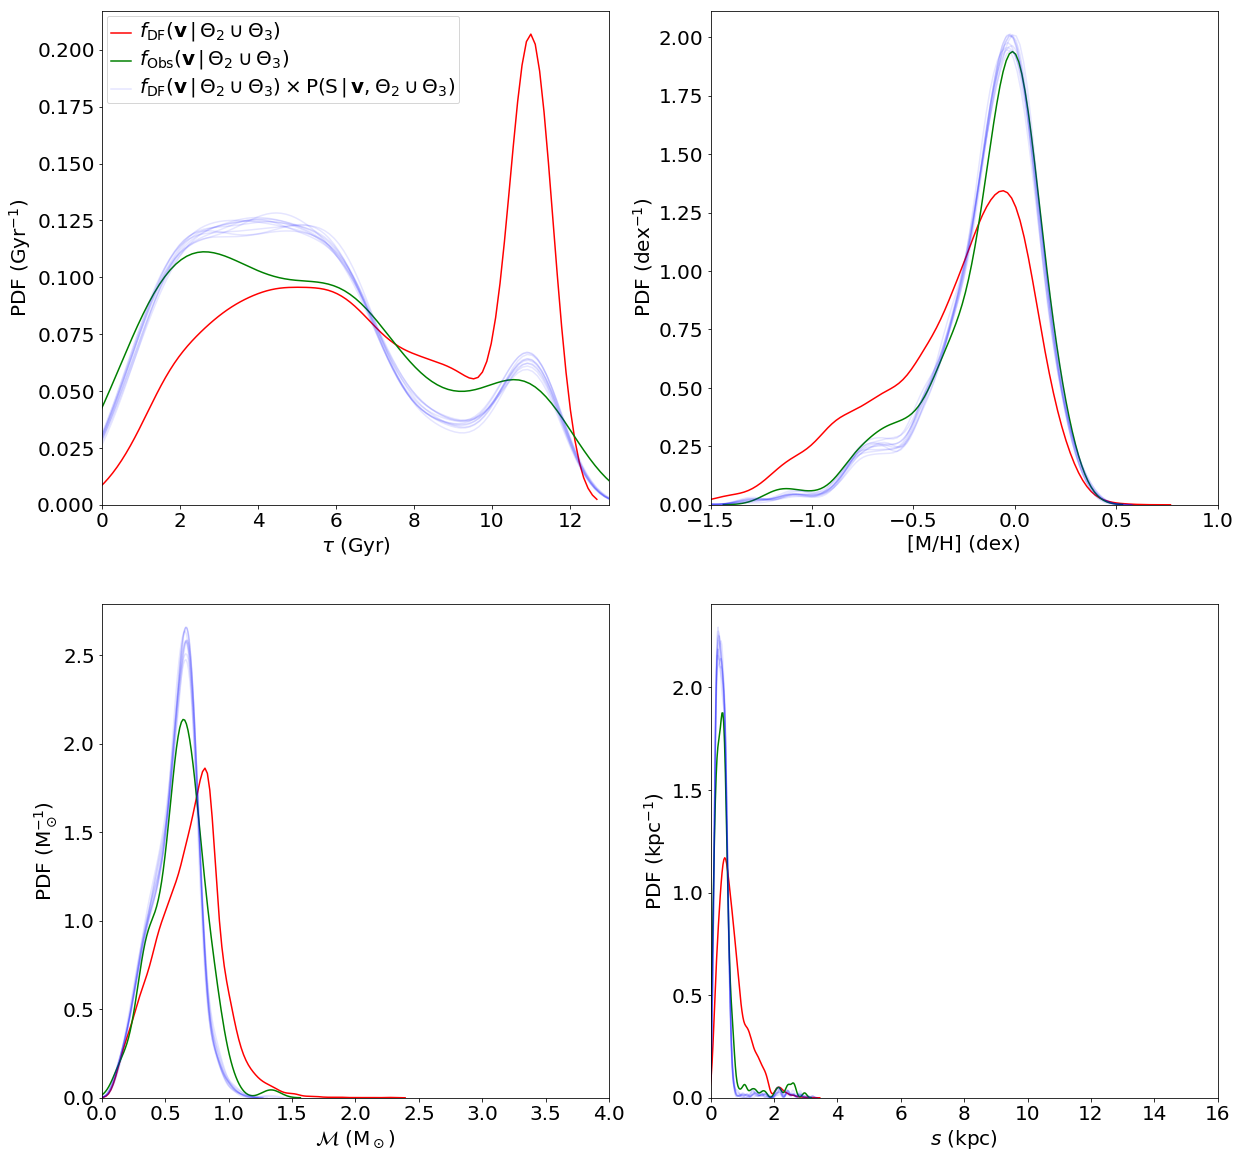

In [63]:
fig, ax = plt.subplots(2, 2, figsize=(20,20))

xlabel = {'mass':r'$\mathcal{M}$ ($\mathrm{M}_\odot$)', 'ageGyr':r'$\tau$ (Gyr)', \
          'mh':r'[M/H] (dex)','s':r'$s$ (kpc)'}
ylabel = {'mass':r'PDF ($\mathrm{M}_\odot^{-1}$)', 'ageGyr':r'PDF ($\mathrm{Gyr}^{-1}$)',\
          'mh':r'PDF ($\mathrm{dex}^{-1}$)', 's':r'PDF ($\mathrm{kpc}^{-1}$)'}
xlim = {'mass':(0,4), 'ageGyr':(0,13), 'mh':(-1.5, 1.0), 's':(0,16)}
coords = ['ageGyr', 'mh', 'mass', 's']

label1=r'$f_\mathrm{DF}(\mathbf{v} \,|\,\Theta_2 \cup \Theta_3)$'
label2=r'$f_\mathrm{Obs}(\mathbf{v} \,|\,\Theta_2 \cup \Theta_3)$'
label3=r'$f_\mathrm{DF}(\mathbf{v} \,|\,\Theta_2 \cup \Theta_3) \times \mathrm{P}(\mathrm{S}\,|\,\mathbf{v}, \Theta_2 \cup \Theta_3)$'

kwargs = {'xlabel':xlabel, 'xlim':xlim, 'fs':20, 'label1':label1, 'label2':label2, 'label3':label3}

kde(full23_c, survey23_c, coords[0], ax[0,0], **kwargs)
kde(full23_c, survey23_c, coords[1], ax[0,1], legend=False, **kwargs)
kde(full23_c, survey23_c, coords[2], ax[1,0], legend=False, **kwargs)
kde(full23_c, survey23_c, coords[3], ax[1,1], legend=False, **kwargs)

#plt.savefig('/home/andy/Documents/Research/SF/WriteUp/SFpaperGit/PaperFigs/G3_intrinsickdes_rand23.png', bbox_inches='tight')